# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time
import utils

In [103]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)
Create a function quilt_random(sample, out_size, patch_size) that randomly samples square patches of size patch_size from a sample in order to create an output image of size out_size. Start from the upper-left corner, and tile samples until the image are full. If the patches don't fit evenly into the output image, you can leave black borders at the edges. This is the simplest but least effective method. Save a result from a sample image to compare to the next two methods.

In [104]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    out_img = np.zeros((out_size, out_size, 3), dtype = "uint8")
    for r in range(0, out_size-patch_size, patch_size):
        for c in range(0, out_size-patch_size, patch_size):
            in_r, in_c = random.randint(0, sample.shape[0]-patch_size), random.randint(0, sample.shape[1]-patch_size)
            out_img[r:(r+patch_size), c:(c+patch_size), :] = sample[in_r:(in_r+patch_size), in_c:(in_c+patch_size), :]
    return out_img

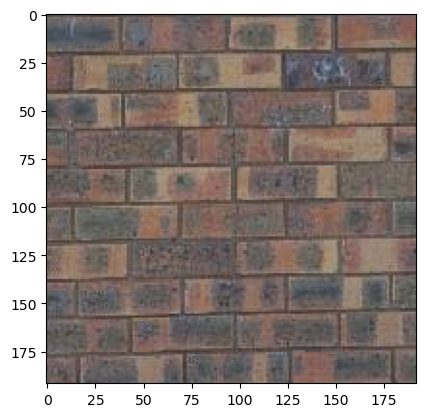

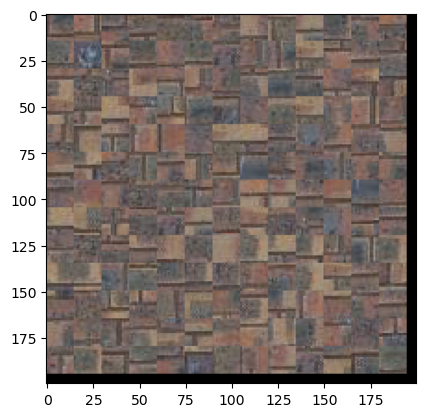

In [105]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [106]:
def ssd_patch(I, T, M, ps):
    """
    performs template matching with the overlapping region, computing the cost of sampling each patch, 
    based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch.

    :param I: numpy.ndarray   Image
    :param T: numpy.ndarray   Template, the patch to be filled in
    :param M: numpy.ndarray   Mask, the mask has the same size as the patch template and has values of 1 in the overlapping region and values of 0 elsewhere
    :param patch_size: int    size of the patch
    :return: numpy.ndarray
    """
    i_r, i_g, i_b = cv2.split(I)
    m_r, m_g, m_b = cv2.split(M)
    t_r, t_g, t_b = cv2.split(T)

    ssd_cost_r = ((m_r*t_r)*2).sum() - 2 * cv2.filter2D(i_r, ddepth=-1, kernel = m_r*t_r) + cv2.filter2D(i_r ** 2, ddepth=-1, kernel=m_r)
    ssd_cost_g = ((m_g*t_g)*2).sum() - 2 * cv2.filter2D(i_g, ddepth=-1, kernel = m_g*t_g) + cv2.filter2D(i_g ** 2, ddepth=-1, kernel=m_g)
    ssd_cost_b = ((m_b*t_b)*2).sum() - 2 * cv2.filter2D(i_b, ddepth=-1, kernel = m_b*t_b) + cv2.filter2D(i_b ** 2, ddepth=-1, kernel=m_b)

    ssd_cost = ssd_cost_r + ssd_cost_g + ssd_cost_b
    
    # make border max value
    s = round(ps / 2)
    maxval = ssd_cost.max()
    ssd_cost[:s,:] = maxval  
    ssd_cost[-s:,:] = maxval  
    ssd_cost[:, :s] = maxval  
    ssd_cost[:, -s:] = maxval 

    return ssd_cost

def choose_sample(sample, cost, tol, ps):
    """
    performs template matching with the overlapping region, computing the cost of sampling each patch, 
    based on the sum of squared differences (SSD) of the overlapping regions of the existing and sampled patch.

    :param sample: numpy.ndarray    The sample image
    :param cost: numpy.ndarray      The cost image where each pixel's value is the cost of selecting the patch centered at that pixel
    :param tol: int                 The tolerance of n min cost that would be randomly sampled from
    :param ps: int                  The patch size
    :return: numpy.ndarray
    """
    ind = np.unravel_index(np.argsort(cost, axis=None), cost.shape)
    t = random.randint(0, tol)
    r, c = ind[0][t], ind[1][t]
    half = np.floor(ps/2).astype(int)
     
    return sample[r-half : r+half+1, c-half : c+half+1].copy()

In [107]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # first patch is random
    out_img = np.zeros((out_size, out_size, 3), dtype = "uint8")
    template = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    in_r, in_c = random.randint(0, sample.shape[0]-patch_size), random.randint(0, sample.shape[1]-patch_size)
    out_img[:(patch_size), :(patch_size), :] = sample[in_r:(in_r+patch_size), in_c:(in_c+patch_size)].copy()

    # first row
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:, :overlap, :] = 1

    for r in range(1, 20):
        template = out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :]
        I = np.float32(sample / 255)
        M = np.float32(mask)
        T = np.float32(template / 255)
        cost = ssd_patch(I,T,M,patch_size)
        chosen = choose_sample(sample, cost, tol, patch_size)
        out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :] = chosen

    # first column
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1

    for c in range(1, 20):
        template = out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :].copy()
        I = np.float32(sample / 255)
        M = np.float32(mask)
        T = np.float32(template / 255)
        cost = ssd_patch(I,T,M,patch_size)
        chosen = choose_sample(sample, cost, tol, patch_size)
        out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :] = chosen



    # the rest
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1
    mask[:, :overlap, :] = 1

    for r in range(1, 20):
        for c in range(1, 20):
            template = out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size].copy()
            I = np.float32(sample / 255)
            M = np.float32(mask)
            T = np.float32(template / 255)
            cost = ssd_patch(I,T,M, patch_size)
            chosen = choose_sample(sample, cost, tol, patch_size)
            out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :] = chosen
    
    return out_img

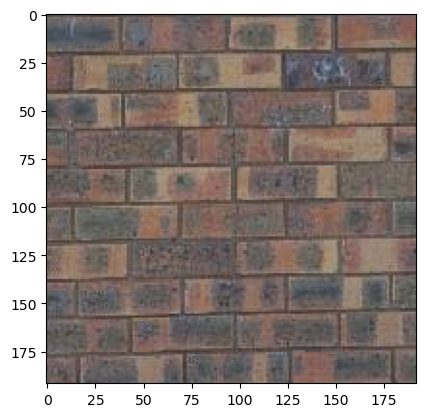

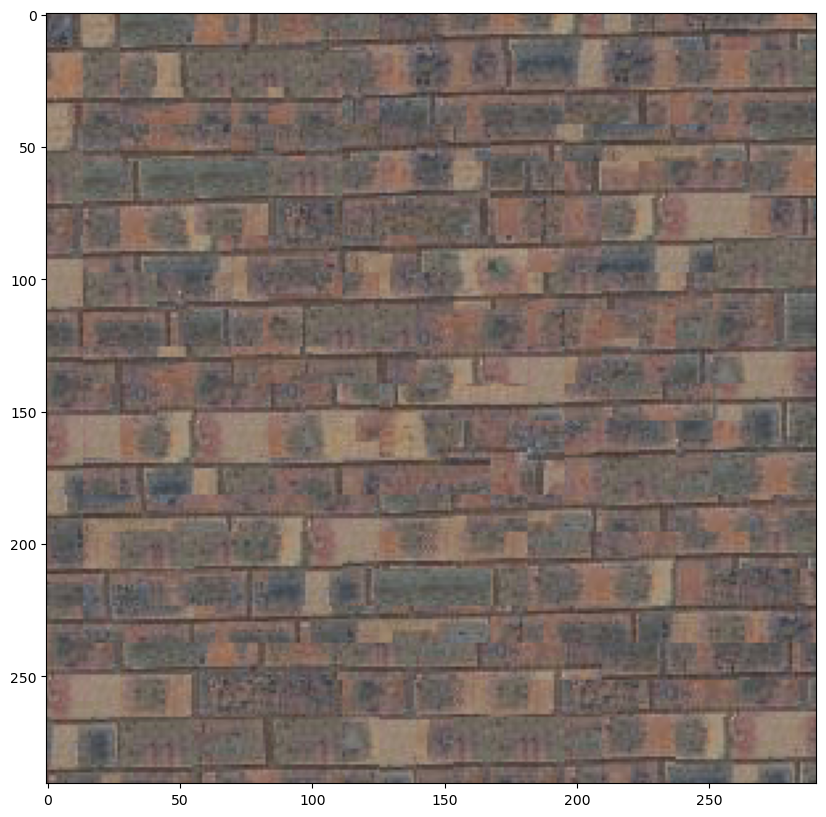

In [108]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 291  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)

In [109]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    a = True
    # first patch is random
    out_img = np.zeros((out_size, out_size, 3), dtype = "uint8")
    template = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    in_r, in_c = random.randint(0, sample.shape[0]-patch_size), random.randint(0, sample.shape[1]-patch_size)
    out_img[:(patch_size), :(patch_size), :] = sample[in_r:(in_r+patch_size), in_c:(in_c+patch_size)].copy()

    # first row
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:, :overlap, :] = 1

    for r in range(1, 20):
        template = out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :]
        I = np.float32(sample / 255).copy()
        M = np.float32(mask).copy()
        T = np.float32(template / 255).copy()
        
        cost = ssd_patch(I,T,M,patch_size)
        chosen = choose_sample(sample, cost, tol, patch_size)
        
        old = T[:patch_size, :overlap].copy()
        new = chosen[:patch_size, :overlap].copy()
    
        
        # finding the cut
        ssd = np.sum((old - new)**2)
        diff = old - new
        err_patch = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
        cut_mask = cut(err_patch.T).T.astype("uint8")
        
        # extend mask to 3d and combine
        cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
        old_cut = cut_mask3d*old
        new_cut = np.logical_not(cut_mask3d)*new
        ovlp = old_cut + new_cut / 255
        
        # add the overlap to chosen patch
        chosen[:patch_size, :overlap] = ovlp * 255
        
        # add to final image
        out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :] = chosen

#         commenting out the visualizations
#         fig, axes = plt.subplots(1, 5)
#         axes[0].imshow(T)
#         axes[1].imshow(chosen)
#         axes[2].imshow(old_cut)
#         axes[3].imshow(new_cut)
#         axes[4].imshow(ovlp);
#         plt.show()
        
#         if a:
#             fig, axes = plt.subplots(1, 4)
#             axes[0].imshow(old)
#             axes[1].imshow(new)
#             axes[2].imshow(err_patch)
#             axes[3].imshow(cut_mask);
#             plt.show()
#             a = False
        
    a = True
    
    # first column
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1

    for c in range(1, 20):
        template = out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :].copy()
        I = np.float32(sample / 255)
        M = np.float32(mask)
        T = np.float32(template / 255)
        cost = ssd_patch(I,T,M,patch_size)
        chosen = choose_sample(sample, cost, tol, patch_size)
        
        # get overlap areas
        old = T[:overlap, :patch_size].copy()
        new = chosen[:overlap, :patch_size].copy()
        
        # finding the cut
        ssd = np.sum((old - new)**2)
        diff = old - new
        err_patch = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
        cut_mask = cut(err_patch).astype("uint8")
        
        # extend mask to 3d and combine
        cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
        old_cut = cut_mask3d*old
        new_cut = np.logical_not(cut_mask3d)*new
        ovlp = old_cut + new_cut / 255
        
        # add the overlap to chosen patch then to final image
        chosen[:overlap, :patch_size] = ovlp * 255
        out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :] = chosen


    a = True
    # the rest
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1
    mask[:, :overlap, :] = 1

    for r in range(1, 20):
        for c in range(1, 20):
            template = out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size].copy()
            I = np.float32(sample / 255)
            M = np.float32(mask)
            T = np.float32(template / 255)
            cost = ssd_patch(I,T,M, patch_size)
            chosen = choose_sample(sample, cost, tol, patch_size)
            
            # mask 1 (horizontal)
            old = T[:overlap, :patch_size].copy()
            new = chosen[:overlap, :patch_size].copy()
            ssd = np.sum((old - new)**2)
            diff = old - new
            err_patch1 = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
            
            # mask 2 (vertical)
            old = T[:patch_size, :overlap].copy()
            new = chosen[:patch_size, :overlap].copy()
            ssd = np.sum((old - new)**2)
            diff = old - new
            err_patch2 = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
            
            # get combined mask
            mask1 = cut(err_patch1).astype("uint8")
            mask2 = cut(err_patch2.T).T.astype("uint8")
            cut_mask = np.zeros((patch_size, patch_size))
            cut_mask[:overlap, :patch_size] = mask1
            cut_mask[:patch_size, :overlap] = mask2
#             cut_mask = np.logical_and(mask2,mask1)
            

            # extend mask to 3d and combine
            cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
            old_cut = cut_mask3d[:patch_size, :overlap]*old
            new_cut = np.logical_not(cut_mask3d[:patch_size, :overlap])*new
            ovlp = old_cut + new_cut / 255

#             if a:
#                 fig, axes = plt.subplots(1, 5)
#                 axes[0].imshow(cut_mask)
#                 axes[1].imshow(chosen)
#                 axes[2].imshow(old_cut)
#                 axes[3].imshow(new_cut)
#                 axes[4].imshow(ovlp);
#                 plt.show()

            # add the overlap to chosen patch then to final image
            chosen[:patch_size, :overlap] = ovlp * 255
            
            out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :] = chosen

    return out_img

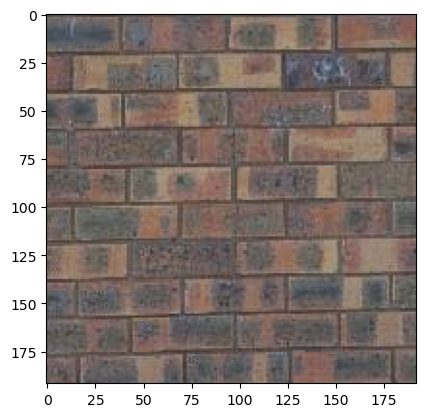

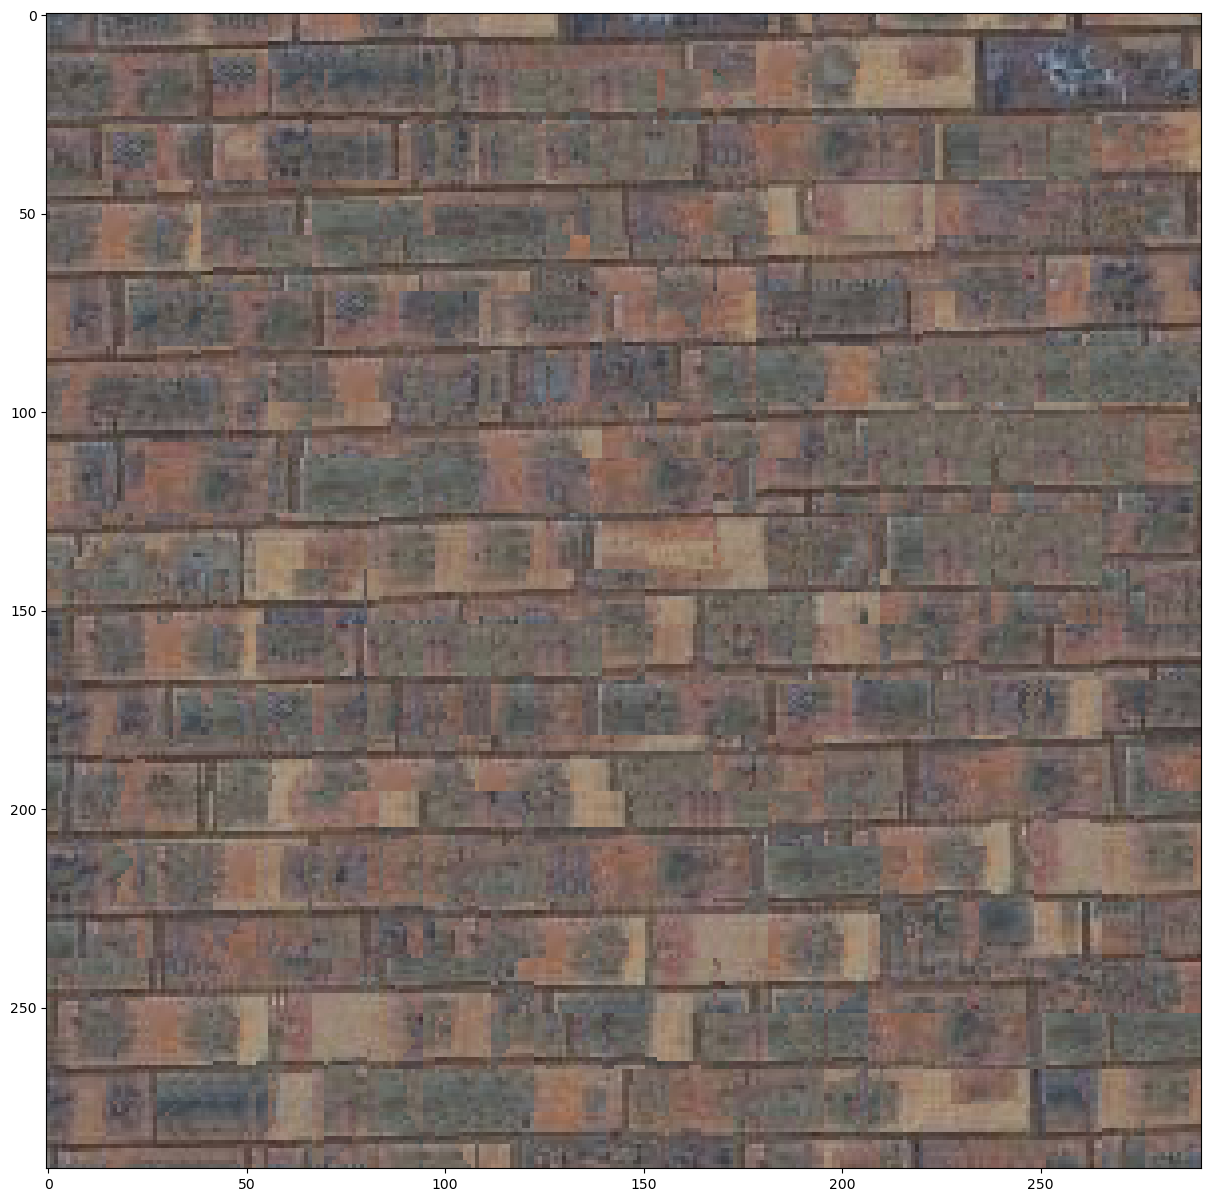

In [110]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 291  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

#### Additional Quilting Results

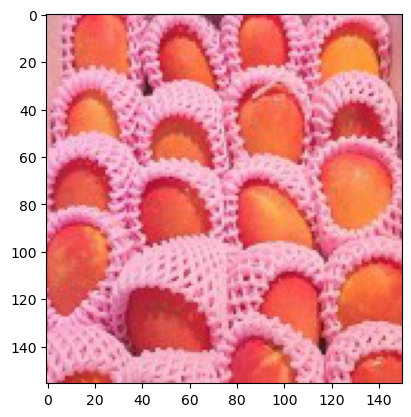

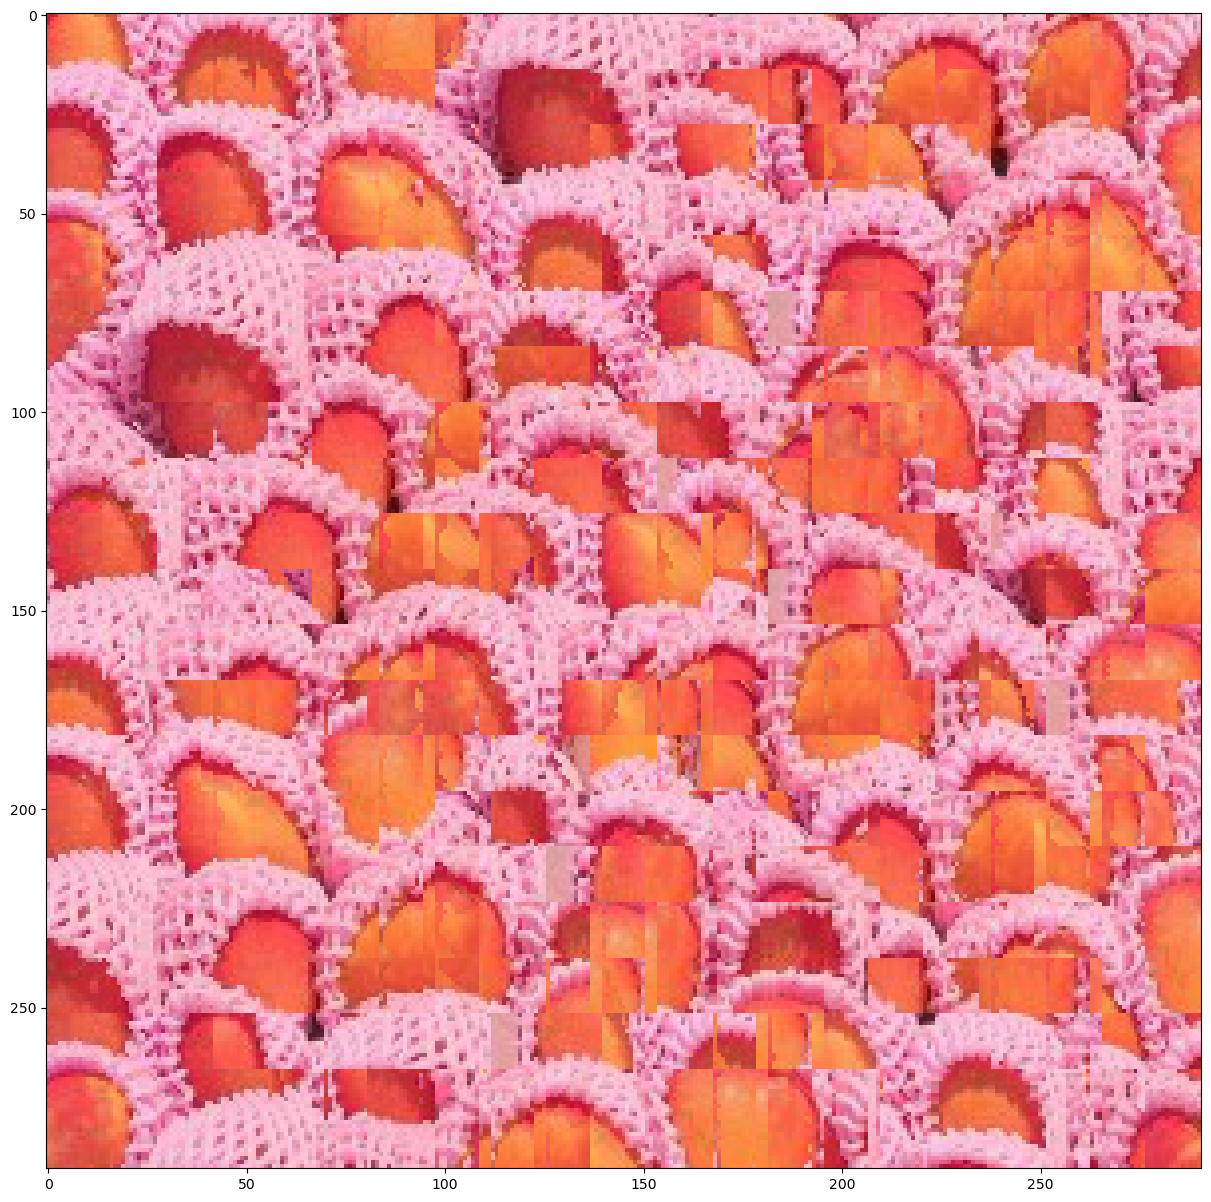

In [111]:
sample_img_fn = 'samples/mango_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 291  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

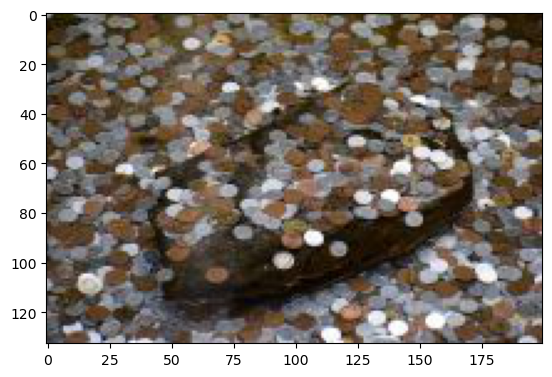

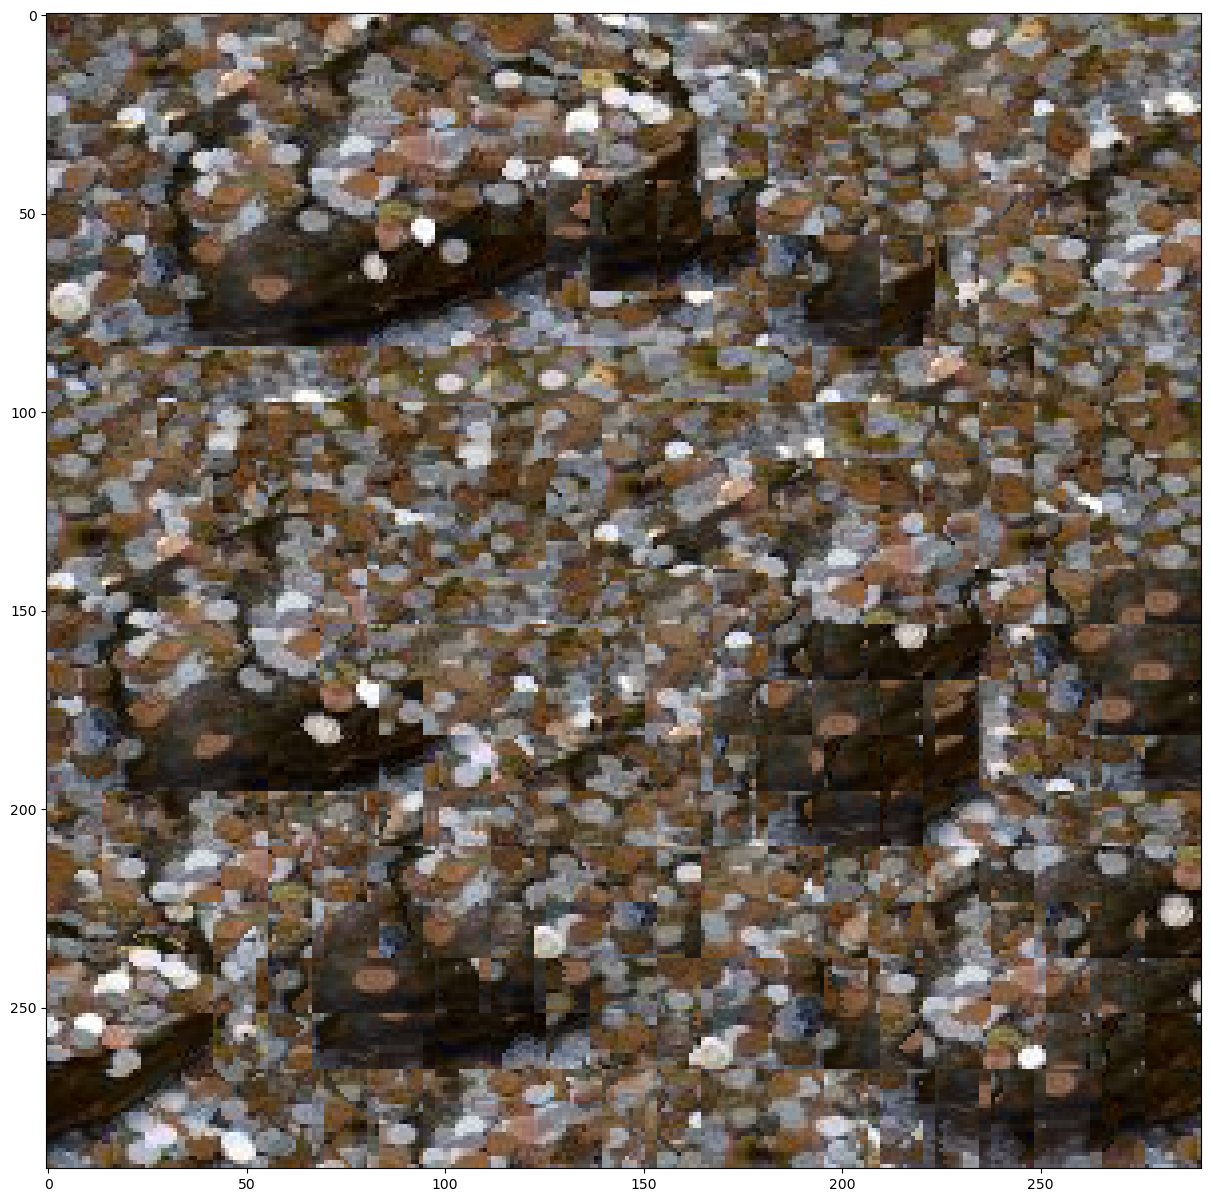

In [112]:
sample_img_fn = 'samples/coins_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 291  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [128]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    h, w, c = guidance_im.shape
    out_img = np.zeros((h, w, 3), dtype = "uint8")
    template = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    in_r, in_c = random.randint(0, sample.shape[0]-patch_size), random.randint(0, sample.shape[1]-patch_size)
    out_img[:(patch_size), :(patch_size), :] = sample[in_r:(in_r+patch_size), in_c:(in_c+patch_size)].copy()

    # first row
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:, :overlap, :] = 1

    for r in range(int((w-patch_size)/(patch_size-overlap))):
        template = out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :].copy()
        I = np.float32(sample / 255).copy()
        M = np.float32(mask).copy()
        M_g = np.ones((patch_size, patch_size, 3), dtype="uint8")
        T = np.float32(template / 255).copy()
        t_g = guidance_im[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :].copy()
        T_g = np.float32(t_g / 255).copy()
        
        # ssd_overlap
        ssd_overlap = ssd_patch(I,T,M,patch_size)
        
        # ssd_guidance
        ssd_guidance = ssd_patch(I,T_g,M_g,patch_size)
        
        cost = alpha * ssd_overlap + (1-alpha) * ssd_guidance
        chosen = choose_sample(sample, cost, tol, patch_size)
        
        old = T[:patch_size, :overlap].copy()
        new = chosen[:patch_size, :overlap].copy()
    
        
        # finding the cut
        ssd = np.sum((old - new)**2)
        diff = old - new
        err_patch = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
        cut_mask = cut(err_patch.T).T.astype("uint8")
        
        # extend mask to 3d and combine
        cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
        old_cut = cut_mask3d*old
        new_cut = np.logical_not(cut_mask3d)*new
        ovlp = old_cut + new_cut / 255
        
        # add the overlap to chosen patch
        chosen[:patch_size, :overlap] = ovlp * 255
        
        # add to final image
        out_img[:patch_size, r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, :] = chosen

#         commenting out the visualizations
#         fig, axes = plt.subplots(1, 5)
#         axes[0].imshow(T)
#         axes[1].imshow(chosen)
#         axes[2].imshow(old_cut)
#         axes[3].imshow(new_cut)
#         axes[4].imshow(ovlp);
#         plt.show()
        
#         if a:
#             fig, axes = plt.subplots(1, 4)
#             axes[0].imshow(old)
#             axes[1].imshow(new)
#             axes[2].imshow(err_patch)
#             axes[3].imshow(cut_mask);
#             plt.show()
#             a = False
        
    a = True
    
    # first column
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1

    for c in range(int((h-patch_size)/(patch_size-overlap))):
        template = out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :].copy()
        I = np.float32(sample / 255)
        M = np.float32(mask)
        T = np.float32(template / 255)
        M_g = np.ones((patch_size, patch_size, 3), dtype="uint8")
        t_g = guidance_im[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :].copy()
        T_g = np.float32(t_g / 255).copy()
        
        # ssd_overlap
        ssd_overlap = ssd_patch(I,T,M,patch_size)
        
        # ssd_guidance
        ssd_guidance = ssd_patch(I,T_g,M_g,patch_size)
        
        cost = alpha * ssd_overlap + (1-alpha) * ssd_guidance
        chosen = choose_sample(sample, cost, tol, patch_size)
        
        # get overlap areas
        old = T[:overlap, :patch_size].copy()
        new = chosen[:overlap, :patch_size].copy()
        
        # finding the cut
        ssd = np.sum((old - new)**2)
        diff = old - new
        err_patch = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
        cut_mask = cut(err_patch).astype("uint8")
        
        # extend mask to 3d and combine
        cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
        old_cut = cut_mask3d*old
        new_cut = np.logical_not(cut_mask3d)*new
        ovlp = old_cut + new_cut / 255
        
        # add the overlap to chosen patch then to final image
        chosen[:overlap, :patch_size] = ovlp * 255
        out_img[c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :patch_size, :] = chosen


    a = True
    # the rest
    mask = np.zeros((patch_size, patch_size, 3), dtype="uint8")
    mask[:overlap, :, :] = 1
    mask[:, :overlap, :] = 1

    for r in range(1, int((h-patch_size)/(patch_size-overlap))):
        for c in range(1, int((w-patch_size)/(patch_size-overlap))):
            template = out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :].copy()
            I = np.float32(sample / 255)
            M = np.float32(mask)
            T = np.float32(template / 255)
            M_g = np.ones((patch_size, patch_size, 3), dtype="uint8")
            t_g = guidance_im[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :].copy()
            T_g = np.float32(t_g / 255).copy()

            # ssd_overlap
            ssd_overlap = ssd_patch(I,T,M,patch_size)

            # ssd_guidance
            ssd_guidance = ssd_patch(I,T_g,M_g,patch_size)

            cost = alpha * ssd_overlap + (1-alpha) * ssd_guidance
            chosen = choose_sample(sample, cost, tol, patch_size)
            
            # mask horizontal
            old = T[:overlap, :patch_size].copy()
            new = chosen[:overlap, :patch_size].copy()
            ssd = np.sum((old - new)**2)
            diff = old - new
            err_patch_h = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
            
            # mask vertical
            old = T[:patch_size, :overlap].copy()
            new = chosen[:patch_size, :overlap].copy()
            ssd = np.sum((old - new)**2)
            diff = old - new
            err_patch_v = diff[:,:,0] ** 2 + diff[:,:,1] ** 2 + diff[:,:,2] ** 2
            
            # get combined mask
            mask_h = cut(err_patch_h).astype("uint8")
            mask_v = cut(err_patch_v.T).T.astype("uint8")

            cut_mask = np.zeros((patch_size, patch_size))
            cut_mask[:overlap, :patch_size] = mask_h
            cut_mask[:patch_size, :overlap] = mask_v

            # extend mask to 3d and combine
            cut_mask3d = np.repeat(cut_mask[:, :, np.newaxis], 3, axis=2)
            old_cut = cut_mask3d[:patch_size, :overlap]*old
            new_cut = np.logical_not(cut_mask3d[:patch_size, :overlap])*new
            ovlp = old_cut + new_cut / 255

#             if a:
#                 fig, axes = plt.subplots(1, 5)
#                 axes[0].imshow(cut_mask)
#                 axes[1].imshow(chosen)
#                 axes[2].imshow(old_cut)
#                 axes[3].imshow(new_cut)
#                 axes[4].imshow(ovlp);
#                 plt.show()

            # add the overlap to chosen patch then to final image
            chosen[:patch_size, :overlap] = ovlp * 255
            out_img[r*(patch_size-overlap):r*(patch_size-overlap)+patch_size, c*(patch_size-overlap):c*(patch_size-overlap)+patch_size, :] = chosen
            
    return out_img

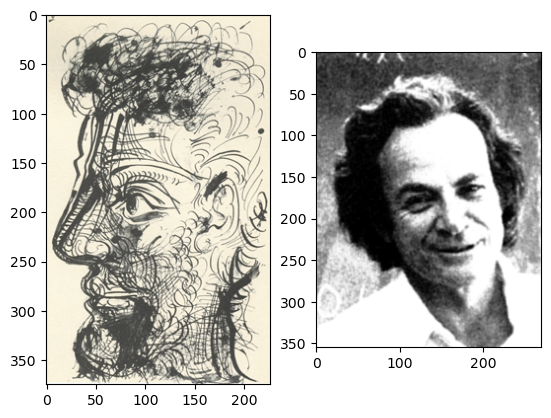

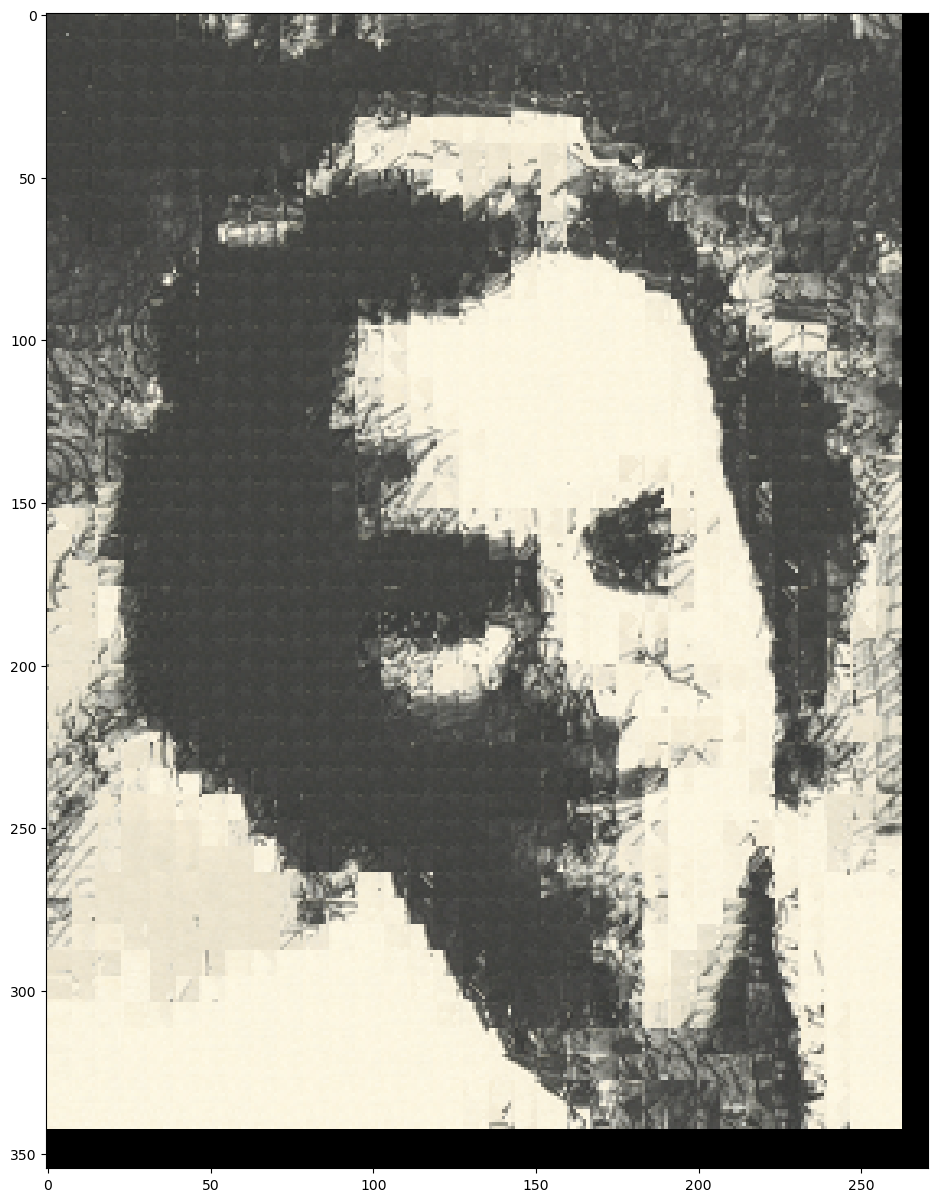

In [129]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(texture_img)
axes[1].imshow(guidance_img)

patch_size = 15
overlap = 7
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

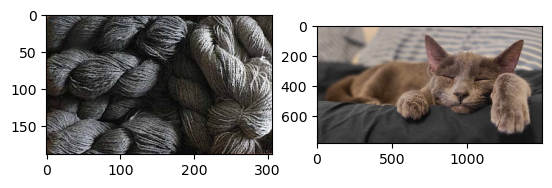

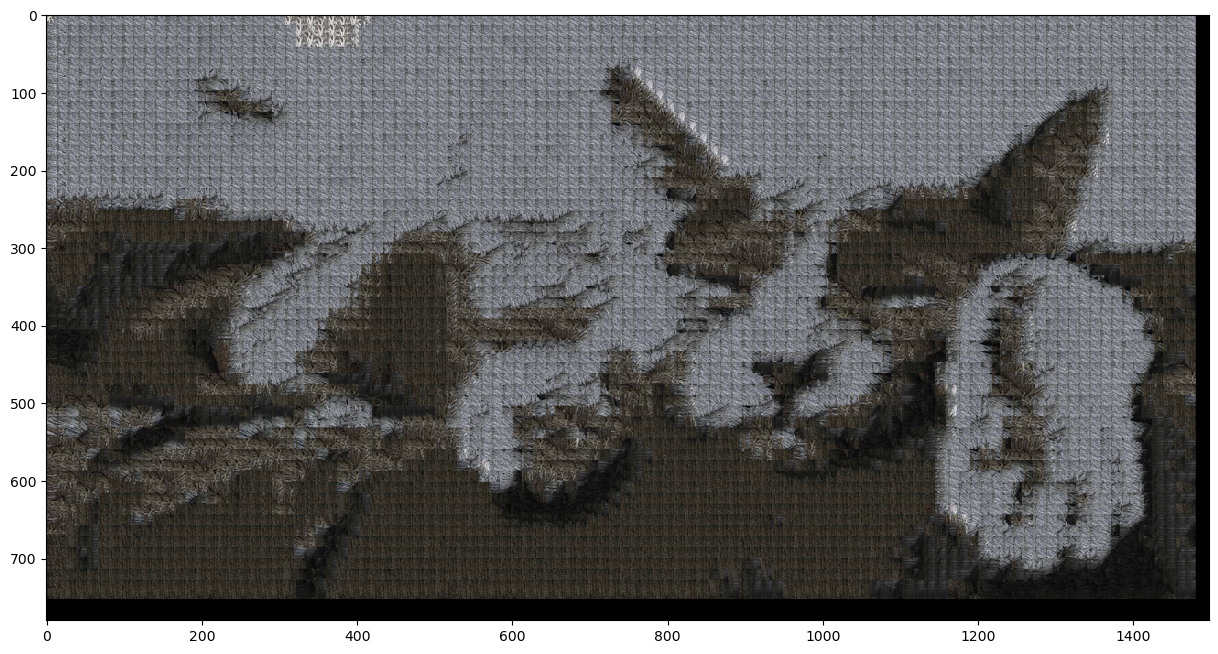

In [132]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/gray_yarn.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/misha.jpeg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(texture_img)
axes[1].imshow(guidance_img)

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).